# Computing Compartment Scores from Simulated Contact Maps

[Copied from Nuebler et al. PNAS (2018) SI]

This score assumes that we know the compartmental type of each monomer. We can use this score for Hi-C maps from simulations, where the types are known by definition. COMPscore1 is computed as follows: for a given distance ​s along the polymer we consider all pairs ​(i,j) with ​j-i=​s, i.e. we consider a diagonal with distance ​s from the main diagonal. For a given ​s we count the the number of pairs ​(i,j) where ​i and ​j belong to the same compartment, ​#pairs_within_comp(s), and to two different compartments, #pairs_across_comp(s). Furthermore, we count the actual number of contacts in the Hi-C map ​hmap such that ​i and ​j belong to the same compartment,

#contacts_within_comp(s) = sum(hmap(i,j) if ​i and ​j from same compartment and ​j-i=​s) 

and analogously for different compartments. From this we define

av_within(s) = ​#contacts_within_comp(s) / #pairs_within_comp(s) ,

which is the average value of the diagonal with distance ​s from the main diagonal of ​hamp restricted to pairs that belong to the same compartment. In the same way we define av_across(s) where the two loci belong to different compartments. From this we compute

COMPscore1(s) = (​av_within(s) - av_across(s)) / (​av_within(s) + av_across(s)) .

This yields a value between -1 and 1, where ​COMPscore1(s)=0 if a contact between ​i and ​j is equally likely whether they belong to the same or different compartments, and COMPscore1(s)=1 if there are only contact within compartments but none across, and COMPscore1(s)=-1 if there are only contacts across compartments. Finally, we average this this measure over all ​s from 0 to L/2, where L is the size of the contact map (we average only up to ​L/2 since there are fewer contacts in the outer parts of the map):

COMPscore1 = <COMPscore1(s)> for s = 0...L/2 .

The properties of this score include: (i) COMPscore1 is insensitive to the absolute number of reads in the matrix (the “sequencing depth”). More precisely, multiplying each entry of ​hmap by a factor does not change the score. (ii) COMPscore1 weighs all distances form the main diagonal equally (i.e. the “scaling” is unimportant); it measures the “contrast” along each diagonal, irrespective of the average value. (iii) COMPscore1 is between -1 and 1, with 0 for no compartment segregation and 1 for perfect compartment segregation.

In [1]:
#Here are the import statements sameer used in his notebook to analyze a simulation
import os
import importlib as imp
from collections import defaultdict
import h5py
import json
from copy import deepcopy
import multiprocessing as mp

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import numpy.ma as ma
import pandas as pd
import scipy
from scipy import stats
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d, interp2d
import seaborn as sns

#import polychrom
#from polychrom import polymer_analyses, contactmaps, polymerutils
#from polychrom.hdf5_format import list_URIs, load_URI, load_hdf5_file

from cooltools import numutils
from cooltools.lib.numutils import (
    observed_over_expected,
    iterative_correction_symmetric,
    LazyToeplitz
)
#import nglutils as ngu
#import nglview as nv

import sys
sys.path.insert(0, '../')

In [2]:
params = {'axes.edgecolor': 'black',
                  'axes.facecolor':'white',
                  'axes.grid': False,
                  'axes.titlesize': 18,
                  'axes.titlepad' : 12,
                  'axes.labelsize': 18,
                  'legend.fontsize': 18,
                  'text.usetex': False,
                  'xtick.labelsize': 18,
                  'ytick.labelsize': 18,
                  'figure.figsize': [5.67, 4.76],
                  #'font.family': 'serif',
                  #'font.serif' : ["Computer Modern Roman"],
                  'mathtext.fontset': 'cm',
                  'xtick.bottom':True,
                  'xtick.top': False,
                  'xtick.direction': 'out',
                  'xtick.major.pad': 3,
                  'xtick.major.size': 4,
                  'xtick.minor.bottom': False,
                  'xtick.major.width': 1.0,
                  'ytick.left':True,
                  'ytick.right':False,
                  'ytick.direction':'out',
                  'ytick.major.pad': 3,
                  'ytick.major.size': 4,
                  'ytick.major.width': 1.0,
                  'ytick.minor.right':False,
                  'lines.linewidth':2}
plt.rcParams.update(params)
textwidth = 6.5

In [19]:
#example contact map -- step 19 x
map = np.load('contactmaps/contact_map_step19x_cutoff2.0.npy')
map_unnormalized = map * 44884

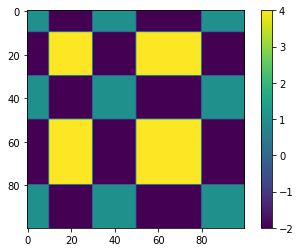

In [29]:
D = np.ones(100) #type B = 1
D[10:30] = -2.0 #type A = -1
D[50:80] = -2.0 #type A = -1
ABidentities = np.outer(D, D)
#yellow (1) means same compartment, purple (-1) means different compartments
im = plt.imshow(ABidentities)
plt.colorbar(im)

Text(0.5, 0, 's')

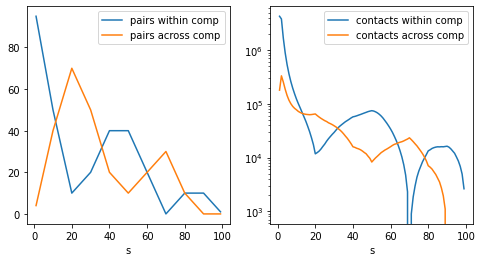

In [27]:
s = np.arange(1, 100)
contacts_within_comp = np.zeros(99)
pairs_within_comp = np.zeros(99)
pairs_across_comp = np.zeros(99)
contacts_across_comp = np.zeros(99)

for i, k in enumerate(s):
    diag_map = np.diag(map_unnormalized, k)
    diag_AB = np.diag(ABidentities, k)
    contacts_within_comp[i] = np.sum(diag_map[diag_AB > 0])
    pairs_within_comp[i] = np.sum(diag_AB > 0)
    contacts_across_comp[i] = np.sum(diag_map[diag_AB < 0])
    pairs_across_comp[i] = np.sum(diag_AB < 0)

fig, ax = plt.subplots(1, 2, figsize=[8,4])
ax[0].plot(s, pairs_within_comp, label='pairs within comp')
ax[0].plot(s, pairs_across_comp, label='pairs across comp')
ax[0].legend()
ax[0].set_xlabel('s')
ax[1].plot(s, contacts_within_comp, label='contacts within comp')
ax[1].plot(s, contacts_across_comp, label='contacts across comp')
ax[1].legend()
ax[1].set_yscale('log')
ax[1].set_xlabel('s')

Average compartment score: 0.1971208267540558


/home/dkannan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/dkannan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


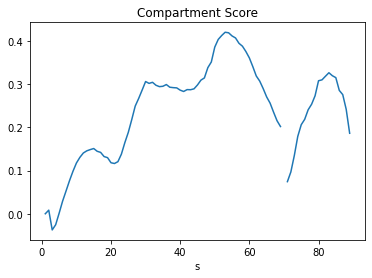

In [28]:
av_within_s = contacts_within_comp / pairs_within_comp
av_across_s = contacts_across_comp / pairs_across_comp
COMPscore1 = (av_within_s - av_across_s)/(av_within_s + av_across_s)
fig, ax  = plt.subplots()
ax.plot(s, COMPscore1)
ax.set_xlabel('s')
ax.set_title('Compartment Score')
avg_COMPscore1 = np.mean(COMPscore1[0:50])
print(f'Average compartment score: {avg_COMPscore1}')

## What about distinguishing AA contacts from BB contacts?


Text(0.5, 0, 's')

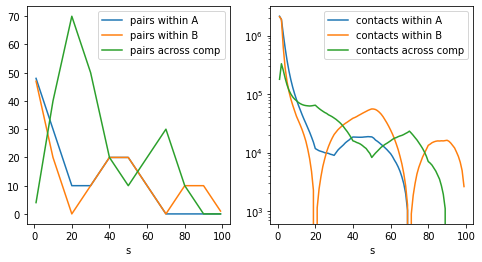

In [30]:
s = np.arange(1, 100)
contacts_within_A = np.zeros(99)
pairs_within_A = np.zeros(99)
contacts_within_B = np.zeros(99)
pairs_within_B = np.zeros(99)
pairs_across_comp = np.zeros(99)
contacts_across_comp = np.zeros(99)

for i, k in enumerate(s):
    diag_map = np.diag(map_unnormalized, k)
    diag_AB = np.diag(ABidentities, k)
    contacts_within_A[i] = np.sum(diag_map[diag_AB == 4])
    pairs_within_A[i] = np.sum(diag_AB == 4)
    contacts_within_B[i] = np.sum(diag_map[diag_AB == 1])
    pairs_within_B[i] = np.sum(diag_AB == 1)
    contacts_across_comp[i] = np.sum(diag_map[diag_AB < 0])
    pairs_across_comp[i] = np.sum(diag_AB < 0)

fig, ax = plt.subplots(1, 2, figsize=[8,4])
ax[0].plot(s, pairs_within_A, label='pairs within A')
ax[0].plot(s, pairs_within_B, label='pairs within B')
ax[0].plot(s, pairs_across_comp, label='pairs across comp')
ax[0].legend()
ax[0].set_xlabel('s')
ax[1].plot(s, contacts_within_A, label='contacts within A')
ax[1].plot(s, contacts_within_B, label='contacts within B')
ax[1].plot(s, contacts_across_comp, label='contacts across comp')
ax[1].legend()
ax[1].set_yscale('log')
ax[1].set_xlabel('s')

Average AA+BB compartment score: 0.1971208267540558
Average AA compartment score: 0.09274081976685565
Average BB compartment score: nan


/home/dkannan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/dkannan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/home/dkannan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


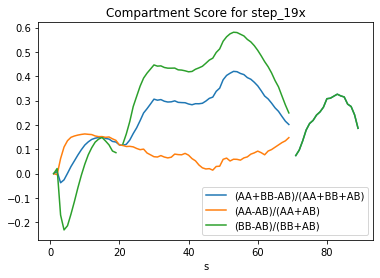

In [37]:
av_withinA_s = contacts_within_A / pairs_within_A
av_withinB_s = contacts_within_B / pairs_within_B
av_across_s = contacts_across_comp / pairs_across_comp
COMPscore1_A = (av_withinA_s - av_across_s)/(av_withinA_s + av_across_s)
COMPscore1_B = (av_withinB_s - av_across_s)/(av_withinB_s + av_across_s)
fig, ax  = plt.subplots()
ax.plot(s, COMPscore1, label='(AA+BB-AB)/(AA+BB+AB)')
ax.plot(s, COMPscore1_A, label='(AA-AB)/(AA+AB)')
ax.plot(s, COMPscore1_B, label='(BB-AB)/(BB+AB)')
ax.legend()
ax.set_xlabel('s')
ax.set_title('Compartment Score for step_19x')
avg_COMPscore1 = np.mean(COMPscore1[0:50])
print(f'Average AA+BB compartment score: {avg_COMPscore1}')
print(f'Average AA compartment score: {np.mean(COMPscore1_A[0:50])}')
print(f'Average BB compartment score: {np.mean(COMPscore1_B[0:50])}')

In [36]:
a = np.ma.array(COMPscore1_B, mask=np.isnan(COMPscore1_B)) 
np.mean(a[0:50])

0.25008270424063145

## Compute metric for all hot-cold simulations

In [242]:
def compute_comp_score(filename, compids=None):
    """ Compute COMP score 2 as a function of distance from diagonal.
    
    Parameters
    ----------
    filename : str
        filename where contact map is stored
    compids : np.ndarray (N,)
        array where -2 is type A and 1 is type B
    
    """
    if compids is None:
        ids = np.load('compartment_identities.npy')[:-1]
        N = len(ids)
        monomer_ids = np.zeros((N,), dtype=int)
        monomer_ids[ids==1] = 1 #type B(cold)
        monomer_ids[ids==-1] = -2 #type A (hot)
        ABidentities = np.outer(monomer_ids, monomer_ids)
    contactmap = np.load(filename)
    N = contactmap.shape[0]
    s = np.arange(1, N)
    contacts_within_A = np.zeros(N-1)
    pairs_within_A = np.zeros(N-1)
    contacts_within_B = np.zeros(N-1)
    pairs_within_B = np.zeros(N-1)
    pairs_across_comp = np.zeros(N-1)
    contacts_across_comp = np.zeros(N-1)

    for i, k in enumerate(s):
        diag_map = np.diag(contactmap, k)
        diag_AB = np.diag(ABidentities, k)
        contacts_within_A[i] = np.sum(diag_map[diag_AB == 4])
        pairs_within_A[i] = np.sum(diag_AB == 4)
        contacts_within_B[i] = np.sum(diag_map[diag_AB == 1])
        pairs_within_B[i] = np.sum(diag_AB == 1)
        contacts_across_comp[i] = np.sum(diag_map[diag_AB < 0])
        pairs_across_comp[i] = np.sum(diag_AB < 0)
    
    av_withinA_s = contacts_within_A / pairs_within_A
    av_withinB_s = contacts_within_B / pairs_within_B
    av_across_s = contacts_across_comp / pairs_across_comp
    av_within_s = (contacts_within_A + contacts_within_B) / (pairs_within_A + pairs_within_B)
    COMPscore1 = (av_within_s - av_across_s)/(av_within_s + av_across_s)
    COMPscore1_A = (av_withinA_s - av_across_s)/(av_withinA_s + av_across_s)
    COMPscore1_B = (av_withinB_s - av_across_s)/(av_withinB_s + av_across_s)
    return COMPscore1, COMPscore1_A, COMPscore1_B
    

In [263]:
COMPscore1_7x, COMPscore1_A_7x, COMPscore1_B_7x = compute_comp_score('contactmaps/contact_map_comps_7x_cutoff2.0.npy')
COMPscore1_4x, COMPscore1_A_4x, COMPscore1_B_4x = compute_comp_score('contactmaps/contact_map_comps_4x_cutoff2.0.npy')
COMPscore1_10x, COMPscore1_A_10x, COMPscore1_B_10x = compute_comp_score('contactmaps/contact_map_comps_10_Deq1_cutoff2.0.npy')
COMPscore1_19x, COMPscore1_A_19x, COMPscore1_B_19x = compute_comp_score('contactmaps/contact_map_comps_19_200runs_cutoff2.0.npy')
                                                                        

/tmp/ipykernel_28284/293077718.py:39: RuntimeWarning: invalid value encountered in true_divide
  av_withinA_s = contacts_within_A / pairs_within_A
/tmp/ipykernel_28284/293077718.py:41: RuntimeWarning: invalid value encountered in true_divide
  av_across_s = contacts_across_comp / pairs_across_comp


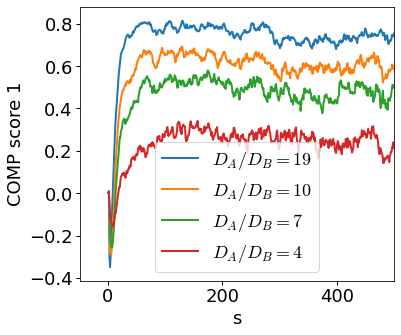

In [285]:
fig, ax = plt.subplots()
srange = np.arange(1, 1000)
ax.plot(srange, COMPscore1_19x, label=r'$D_A / D_B = 19$')
ax.plot(srange, COMPscore1_10x, label=r'$D_A / D_B = 10$')
ax.plot(srange, COMPscore1_7x, label=r'$D_A / D_B = 7$')
ax.plot(srange, COMPscore1_4x, label=r'$D_A / D_B = 4$')
ax.legend()
ax.set_xlabel('s')
ax.set_ylabel('COMP score 1')
plt.xlim(right=500)
fig.tight_layout()
plt.savefig('plots/COMPscore1_4_ratios.pdf')

In [276]:
hot_cold = [4, 7, 10, 19]
compscore1s = [COMPscore1_4x[100:500].mean(), COMPscore1_7x[100:500].mean(), 
               COMPscore1_10x[100:500].mean(), COMPscore1_19x[100:500].mean()]
compscore2s = []
quantiles = np.linspace(0, Q_HI, N_GROUPS + 2)
ind = int(25 // 2.5)
print(quantiles[ind])
AA_oe, BB_oe, AB_oe, AA_ratios, BB_ratios, ratios = saddle_strength_A_B(S_4x, C_4x)
compscore2s.append((ratios[ind] - 1) / (ratios[ind] + 1))
AA_oe, BB_oe, AB_oe, AA_ratios, BB_ratios, ratios = saddle_strength_A_B(S_7x, C_7x)
compscore2s.append((ratios[ind] - 1) / (ratios[ind] + 1))
AA_oe, BB_oe, AB_oe, AA_ratios, BB_ratios, ratios = saddle_strength_A_B(S_10x, C_10x)
compscore2s.append((ratios[ind] - 1) / (ratios[ind] + 1))
AA_oe, BB_oe, AB_oe, AA_ratios, BB_ratios, ratios = saddle_strength_A_B(S, C)
compscore2s.append((ratios[ind] - 1) / (ratios[ind] + 1))

0.24999999999999997


[0.2608551356125438, 0.4903281836622074, 0.6143197117132712, 0.7512148981411606]
[0.28784130191178, 0.5782962368429144, 0.7099958824090404, 0.8492413635204299]
[4, 7, 10, 19]


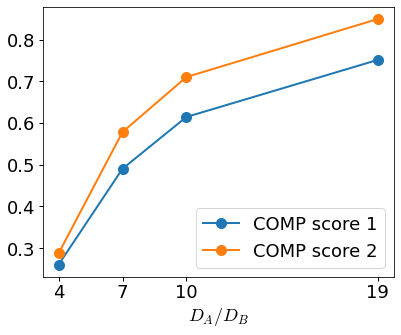

In [284]:
print(compscore1s)
print(compscore2s)
print(hot_cold)
fig, ax = plt.subplots()
ax.plot(hot_cold, compscore1s, '-o', label='COMP score 1', markersize=10)
ax.plot(hot_cold, compscore2s, '-o', label='COMP score 2', markersize=10)
plt.xticks(hot_cold, ['4', '7', '10', '19'])
plt.legend()
plt.xlabel(r'$D_A / D_B$')
fig.tight_layout()
plt.savefig('plots/comp_scores_1_2_4ratios.pdf')

In [287]:
np.save('compscore1s_4ratios.npy', compscore1s)

In [288]:
np.save('compscore2s_4ratios.npy', compscore2s)

# Generate compartmentalization pattern

In [17]:
def compartmentalization_pattern(N, c1, c2, p=0.8, hot_cold=19, 
                                 Deq=1.0, start_hot=True):
    """ Make a NxN correlation matrix that resembles a compartmentalization pattern
    from Hi-C. Returns binary sequence where 1's correspond to active regions and 0's
    correspond to inactive regions."""
    identities = np.ones(N,)
    #define discrete probability distribution with pmf(x) = x/d * exp(-x/d)
    grid = np.arange(0, N)
    pk = grid/(0.5*c1) * np.exp(-grid / (0.5*c1))
    pk /= np.sum(pk)
    rvc1 = stats.rv_discrete(name='custm', values=(grid, pk))
    pk2 = grid/(0.5*c2) * np.exp(-grid / (0.5*c2))
    pk2 /= np.sum(pk2)
    rvc2 = stats.rv_discrete(name='custm2', values=(grid, pk2))
    #calculate deviation from D=1, where Dhot = D + x and Dcold = D - x
    x = (hot_cold - 1)/(hot_cold + 1)
    Dhot = Deq + x
    Dcold = Deq - x
    i = 0
    if start_hot:
        id = 1
    else:
        id = -1
    while i < N:
        block = rvc1.rvs()
        if (i + block > N):
            break
        identities[i:(i + block)] = id
        i += block
        if np.random.binomial(1, p):
            block = rvc2.rvs() #smaller block
        else:
            block = rvc1.rvs()
        if (i + block > N):
            break
        identities[i : (i + block)] = -1*id
        i += block
    identities[identities == 1] = Dhot
    identities[identities == -1] = Dcold
    return identities

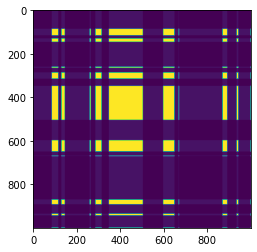

In [30]:
D = compartmentalization_pattern(1000, 70, 20, start_hot=False)
plt.imshow(np.outer(D, D))

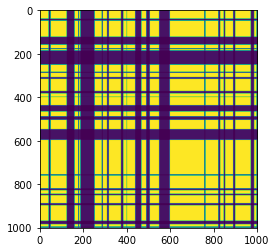

In [27]:
ids = np.load('compartment_identities.npy')
ids[ids==1] = 1.9
ids[ids==-1] = 0.1
plt.imshow(np.outer(ids, ids))

In [194]:
1.0 - 3/5


0.4

In [195]:
1.0 + 3/5

1.6

# Process simulated maps in the same manner as HiC

In [2]:
import cooltools.lib.plotting
from cooltools.lib.numutils import (
    observed_over_expected,
    iterative_correction_symmetric,
    LazyToeplitz
)
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker

In [3]:
#load contact maps with cutoff radius = 2.0
comp19x_map = np.load('/home/dkannan/git-remotes/polychrom/contactmaps/contact_map_comps_19_200runs_cutoff2.0.npy')
comp10x_map = np.load('/home/dkannan/git-remotes/polychrom/contactmaps/contact_map_comps_10_Deq1_cutoff2.0.npy')


In [5]:
comp19x_map.max()

1.0

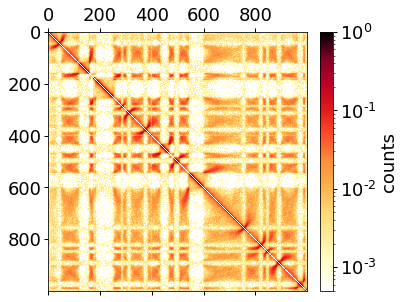

In [22]:
norm = LogNorm(vmax=1.0)
fig, ax = plt.subplots()
im = ax.matshow(
    comp19x_map,
    cmap='fall',
    norm=norm,
);
plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='counts')

In [7]:
comp19x_balanced, totalBias, report = iterative_correction_symmetric(comp19x_map, max_iter=50)

In [8]:
comp19x_balanced /= np.mean(comp19x_balanced.sum(axis=1))

In [159]:
comp19x_balanced.max()

0.20662917115695137

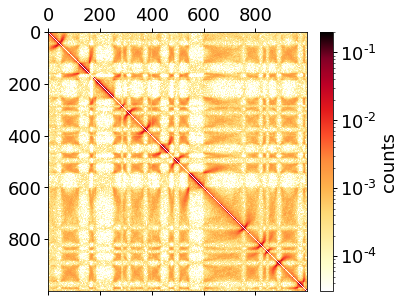

In [24]:
norm = LogNorm(vmax=0.2)
fig, ax = plt.subplots()
im = ax.matshow(
    comp19x_balanced,
    cmap='fall',
    norm=norm,
);
plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='counts')

In [160]:
comp19x_oe, dist_bins, sum_pixels, n_pixels = observed_over_expected(comp19x_balanced)

In [161]:
comp19x_oe.max()

13.420197476838839

In [75]:
np.ones((5,5), dtype="bool")

array([[ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True]])

## Write my own observed over expected code

In [3]:
def obs_exp(mat, mask=None):
    """ Compute observed over expected from raw contact map by dividing each diagonal by the mean.
    
    Parameters
    ----------
    mat : np.ndarray[float] (N, N)
        contact map
    mask : np.ndarray[bool] (N, N)
        regions that are masked out
    """
    Pofs = np.zeros((mat.shape[0],))
    Pofs[0] = 1.0 #main diagonal -- 100% probability of contact
    if mask is None:
        mask = np.ones(mat.shape, dtype="bool")
    for k in range(1, mat.shape[0]):
        diag = np.diag(mat, k)
        mask_diag = np.diag(mask, k)
        Pofs[k] = np.nanmean(diag[mask_diag])
    exp = LazyToeplitz(Pofs)
    oe = mat / exp[:, :]
    return oe, Pofs

In [4]:
def draw_power_law_triangle(alpha, x0, width, orientation, base=10,
                            hypotenuse_only=False, **kwargs):
    """Draw a triangle showing the best-fit power-law on a log-log scale.

    Parameters
    ----------
    alpha : float
        the power-law slope being demonstrated
    x0 : (2,) array_like
        the "left tip" of the power law triangle, where the hypotenuse starts
        (in log units, to be consistent with draw_triangle)
    width : float
        horizontal size in number of major log ticks (default base-10)
    orientation : string
        'up' or 'down', control which way the triangle's right angle "points"
    base : float
        scale "width" for non-base 10

    Returns
    -------
    corner : (2,) np.array
        coordinates of the right-angled corner of the triangle
    """
    if 'color' in kwargs:
        color = kwargs['color']
    else:
        color = 'k'
    x0, y0 = [base**x for x in x0]
    x1 = x0*base**width
    y1 = y0*(x1/x0)**alpha
    plt.plot([x0, x1], [y0, y1], 'k')
    if (alpha >= 0 and orientation == 'up') \
    or (alpha < 0 and orientation == 'down'):
        if hypotenuse_only:
            plt.plot([x0, x1], [y0, y1], color=color, **kwargs)
        else:
            plt.plot([x0, x1], [y1, y1], color=color, **kwargs)
            plt.plot([x0, x0], [y0, y1], color=color, **kwargs)
        # plt.plot lines have nice rounded caps
        # plt.hlines(y1, x0, x1, **kwargs)
        # plt.vlines(x0, y0, y1, **kwargs)
        corner = [x0, y1]
    elif (alpha >= 0 and orientation == 'down') \
    or (alpha < 0 and orientation == 'up'):
        if hypotenuse_only:
            plt.plot([x0, x1], [y0, y1], color=color, **kwargs)
        else:
            plt.plot([x0, x1], [y0, y0], color=color, **kwargs)
            plt.plot([x1, x1], [y0, y1], color=color, **kwargs)
        # plt.hlines(y0, x0, x1, **kwargs)
        # plt.vlines(x1, y0, y1, **kwargs)
        corner = [x1, y0]
    else:
        raise ValueError(r"Need $\alpha\in\mathbb{R} and orientation\in{'up', 'down'}")
    return corner

In [32]:
comp19x_oe2, Pofs = obs_exp(comp19x_balanced)

In [32]:
def plot_pofs(Pofs_curves, labels, figname, curve_scaling_ind=1, xscale=1.0):
    fig, ax = plt.subplots()
    for i, Pofs in enumerate(Pofs_curves):
        sdistances = np.arange(0, len(Pofs), dtype='float')
        sdistances *= xscale
        ax.plot(sdistances[1:], Pofs[1:], label=labels[i])
    #extract scaling from one of the curves with curve_scaling_ind
    result = scipy.stats.linregress(np.log10(sdistances[2:10]), np.log10(Pofs_curves[curve_scaling_ind][2:10]))
    print(result.slope)
    corner = draw_power_law_triangle(-1, [1, -1.6], 0.5, 'up', base=10,
                            hypotenuse_only=False)
    #ax.text(12.0, 0.006, r'$s^{-1}$', fontsize=16)
    plt.yscale('log')
    plt.xscale('log')
    plt.xlim(left=2)
    ax.set_xlabel('s')
    ax.set_ylabel(f'Expected (mean of diagonal)')
    plt.legend()
    fig.tight_layout()
    plt.savefig(f'../plots/pofs_{figname}.pdf')
    plt.show()

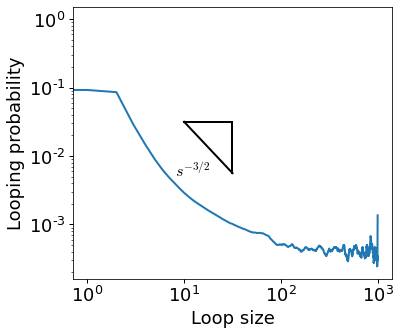

In [47]:
plot_pofs(Pofs, 'comps_19x')

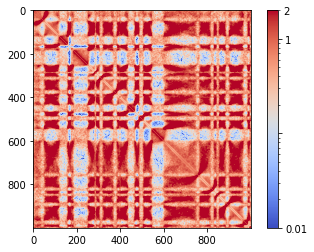

In [13]:
vmin = 0.01
vmax = 2.0
class MinOneMaxFormatter(ticker.LogFormatter):
    def set_locs(self, locs=None):
        self._sublabels = set([vmin % 10 * 10, vmax % 10, 1])

    def __call__(self, x, pos=None):
        if x not in [vmin, 1, vmax]:
            return ""
        else:
            return "{x:g}".format(x=x)

norm = LogNorm(vmax=vmax, vmin=vmin)
im = plt.imshow(comp19x_oe, cmap="coolwarm", norm=norm)
cb = plt.colorbar(im, format=MinOneMaxFormatter())
cb.ax.yaxis.set_minor_formatter(MinOneMaxFormatter())

In [137]:
np.mean(comp19x_oe2)

0.9989999999999998

## Comparing experimental and simulated contact scalings

In [28]:
sim_map = np.load('../data/contact_map_bcomps_5.974x_cutoff2.0.npy')
sim_eq = np.load('../data/contact_map_Deq1_cutoff2.0.npy')
#balance the map
mat_balanced, totalBias, report = iterative_correction_symmetric(sim_map, max_iter=50)
mat_balanced, totalBias, report = iterative_correction_symmetric(sim_eq, max_iter=50)
#mat_balanced /= np.mean(mat_balanced.sum(axis=1))
#sim_map = mat_balanced
#note this is balanced
exp_map = np.load('/net/levsha/share/deepti/data/blobel_chr2_35_60Mb_25kb_resolution_map.npy')
print(sim_map.shape)
print(exp_map.shape)

(1000, 1000)
(1000, 1000)


In [19]:
%matplotlib notebook

/tmp/ipykernel_14460/4107874071.py:20: RuntimeWarning: invalid value encountered in true_divide
  oe = mat / exp[:, :]


<IPython.core.display.Javascript object>


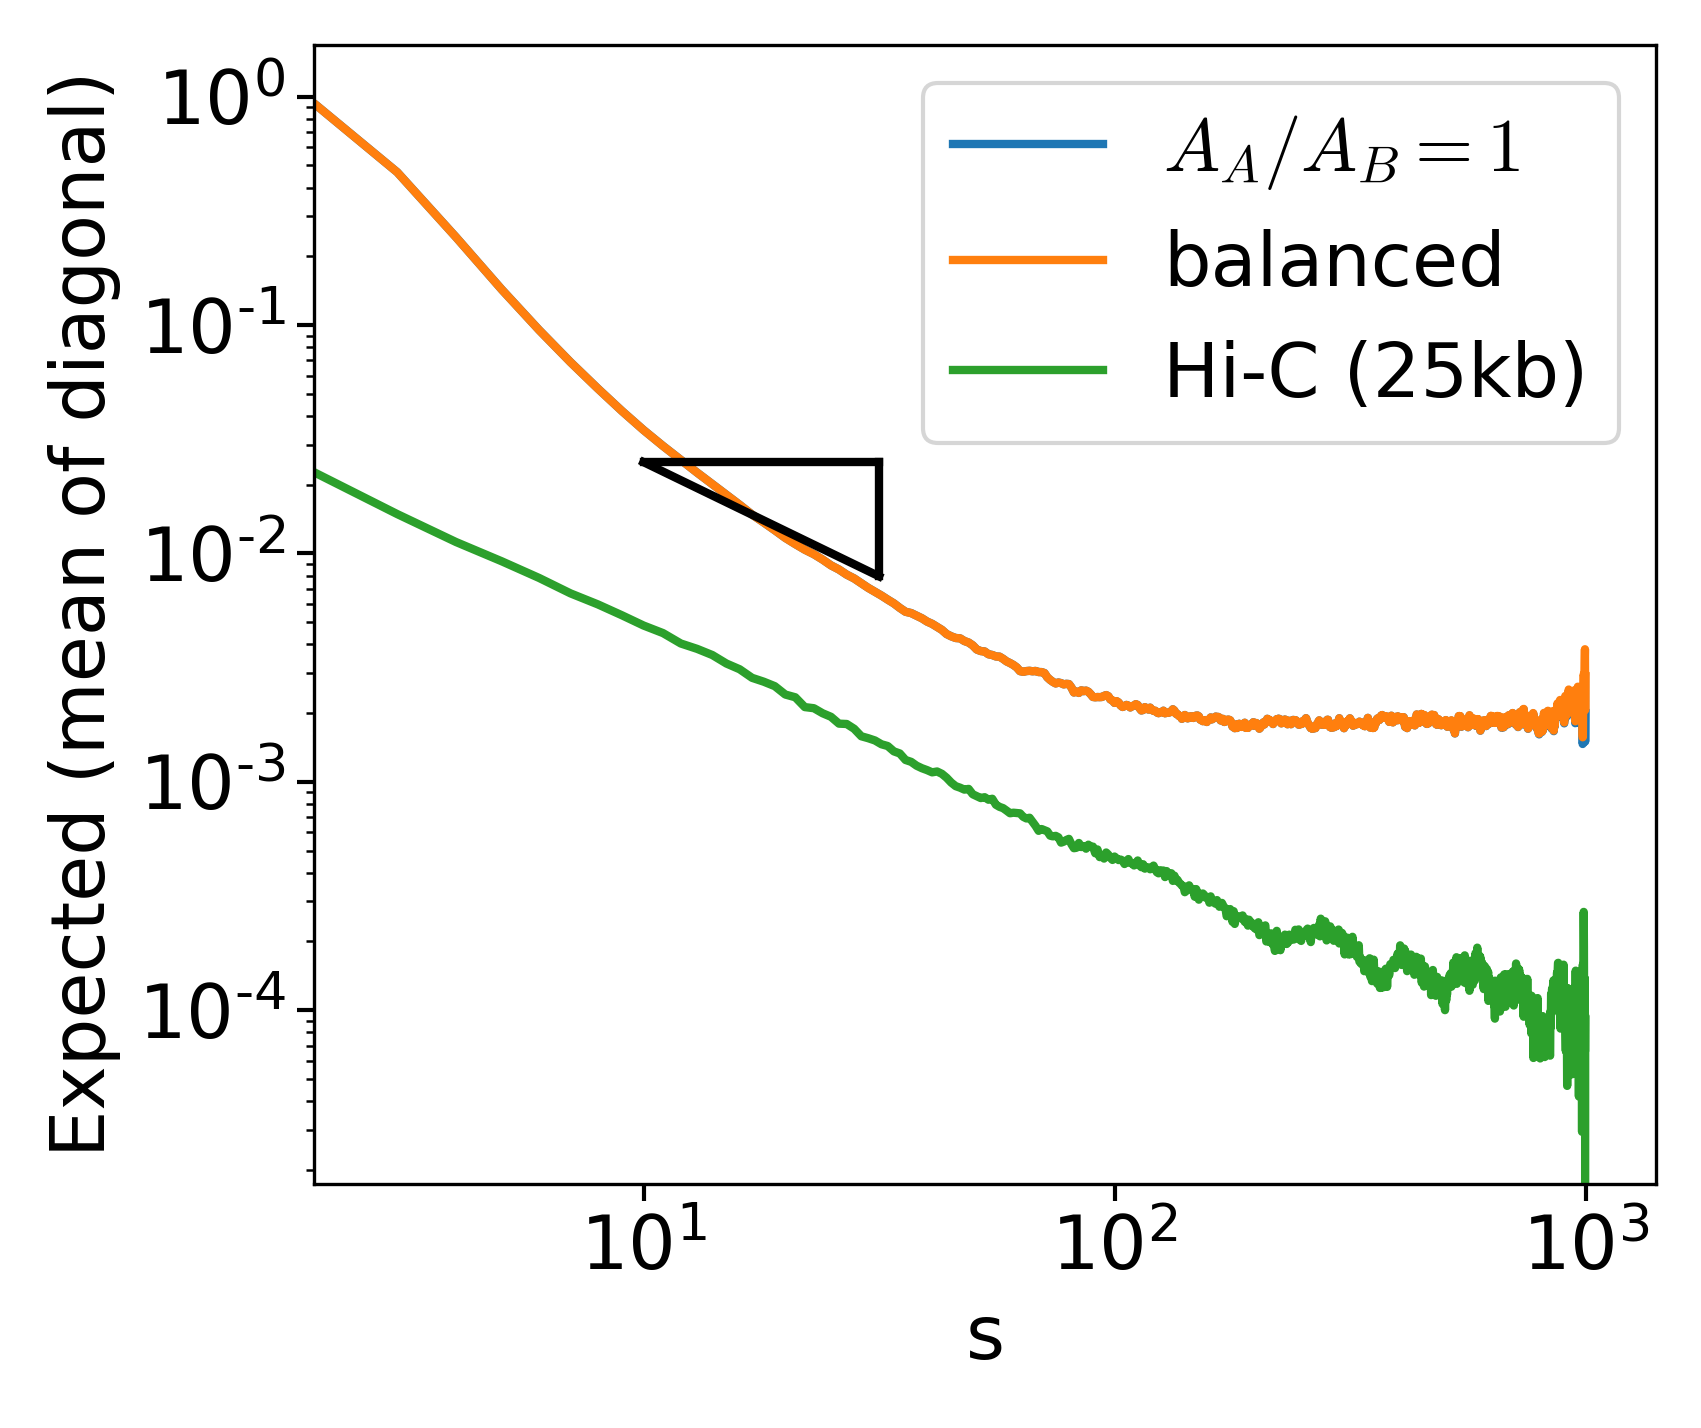

-2.119902259692637


In [33]:
#Plot p of s scaling of balanced maps for experiment and simulation
sim_oe2, sim_Pofs = obs_exp(sim_map)
eq_oe2, eq_Pofs = obs_exp(sim_eq)
eq_balanced, eq_balanced_Pofs = obs_exp(mat_balanced)
exp_oe2, exp_Pofs = obs_exp(exp_map)
plot_pofs([eq_Pofs, eq_balanced_Pofs, exp_Pofs], [r'$A_A / A_B = 1$', 'balanced','Hi-C (25kb)'], 'sim_exp_comparison')

In [12]:
np.nansum(exp_map, axis=0)

array([0.58415725, 0.77914125, 0.84053016, 0.73829723, 0.78912568,
       0.95517835, 1.09414352, 0.93408941, 0.97026958, 1.0711785 ,
       0.97794226, 1.00529564, 1.03556972, 0.94293986, 1.02268287,
       0.9724185 , 0.96578158, 0.94571464, 0.98436341, 0.98258258,
       0.97825527, 0.97848248, 0.91006444, 0.93232003, 0.97763436,
       0.92506372, 0.91569781, 0.94099374, 0.93750937, 0.9275922 ,
       0.91474029, 0.96075058, 0.96973192, 0.88879482, 0.99718517,
       0.9878049 , 0.91372459, 0.93179664, 0.92072368, 0.9089673 ,
       0.94967947, 0.86753225, 0.89627803, 0.92394464, 0.92045366,
       0.94721087, 1.00218325, 0.98245617, 0.91587632, 0.90268081,
       0.82230068, 0.93906007, 0.83893314, 0.92706653, 0.        ,
       0.8028501 , 1.06005604, 0.92849612, 0.92234999, 0.85374301,
       1.01101468, 0.92022549, 0.87669055, 0.9151073 , 0.83983493,
       0.86072876, 0.91507819, 0.9200421 , 0.90898488, 0.90153561,
       0.90983045, 0.85583963, 0.89276389, 0.80535734, 0.94145

## Compute eigenvector

In [61]:
comp19x_oe -= 1.0 #first mean center the OE matrix
eigvecs, eigvals = numutils.get_eig(comp19x_oe, 3, mask_zero_rows=True)
eigvecs /= np.sqrt(np.nansum(eigvecs ** 2, axis=1))[:, None]
eigvecs *= np.sqrt(np.abs(eigvals))[:, None]

In [62]:
e1_19x = eigvecs[0]

In [196]:
def plot_E1_simulated_contact_map(contact_map, e1, tag, lines=False):
    fig, ax = plt.subplots(
            figsize=(15, 10),
    )

    norm = LogNorm(vmax=0.2)

    im = ax.matshow(
        contact_map,
        norm=norm,
        cmap='fall'
    );
    plt.axis([0,1000,1000,0])

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax, label='balanced contact frequencies');

    cax2 = divider.append_axes("left", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax2, label='observed / expected');
    ax.set_xlabel('1000 monomers')
    ax.yaxis.set_visible(False)

    ax1 = divider.append_axes("top", size="20%", pad=0.25, sharex=ax)
    ax1.plot([0,1000],[0,0],'k',lw=0.25)
    ax1.plot(e1, label='E1')
    
    if lines:
        for i in np.where(np.diff((e1>0).astype(int)))[0]:
            ax.plot([0, 1000],[i,i],'k',lw=0.5)
            ax.plot([i,i],[0, 1000],'k',lw=0.5)

    ax1.set_ylabel('E1')
    ax1.set_xticks([]);
    if lines:
        plt.savefig(f'plots/contact_map_e1_balanced_lines_{tag}.pdf')
    else:
        plt.savefig(f'plots/contact_map_e1_balanced_{tag}.pdf')

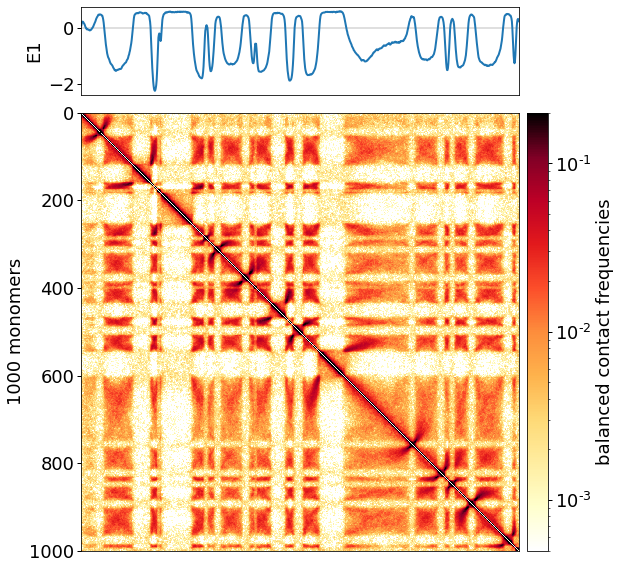

In [197]:
plot_E1_simulated_contact_map(comp19x_map, e1_19x, 'comp19x', lines=False)

In [166]:
comp10x_balanced, totalBias, report = iterative_correction_symmetric(comp10x_map, max_iter=50)
comp10x_balanced /= np.mean(comp10x_balanced.sum(axis=1))

In [167]:
comp10x_oe, dist_bins, sum_pixels, n_pixels = observed_over_expected(comp10x_balanced)
comp10x_oe.max()

12.153848534719197

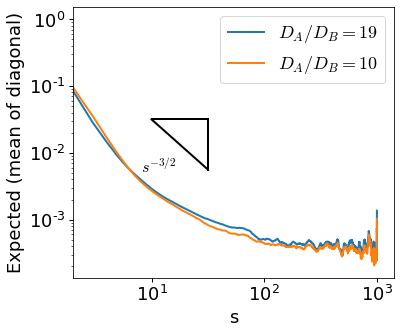

In [68]:
comp10x_oe2, Pofs_10x = obs_exp(comp10x_balanced)
plot_pofs([Pofs, Pofs_10x], [r'$D_A / D_B = 19$', r'$D_A / D_B = 10$'], 'sim_comps_19_19')

In [56]:
comp10x_oe -= 1.0 #first mean center the OE matrix
eigvecs, eigvals = numutils.get_eig(comp10x_oe, 3, mask_zero_rows=True)
eigvecs /= np.sqrt(np.nansum(eigvecs ** 2, axis=1))[:, None]
eigvecs *= np.sqrt(np.abs(eigvals))[:, None]
e1_10x = eigvecs[0]

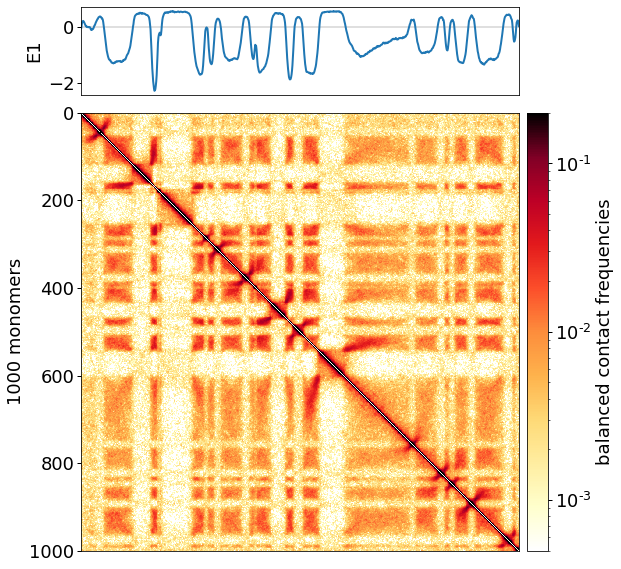

In [198]:
plot_E1_simulated_contact_map(comp10x_map, e1_10x, 'comp10x', lines=False)

<Figure size 408.24x342.72 with 0 Axes>

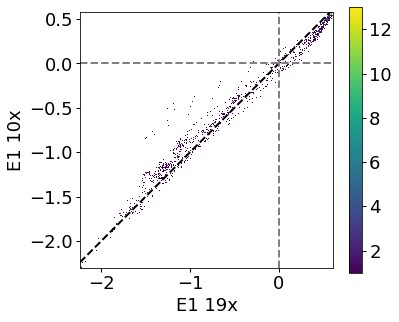

In [70]:
from datashader.mpl_ext import dsshow, alpha_colormap
import datashader as ds

fig = plt.figure()
df = pd.DataFrame()
df['19x'] = e1_19x
df['10x'] = e1_10x
artist = dsshow(df, ds.Point('19x', '10x'), ds.count(), aspect='equal')
plt.colorbar(artist)
ymin, ymax = plt.gca().get_ylim()
xmin, xmax = plt.gca().get_xlim()
plt.xlabel('E1 19x')
plt.ylabel('E1 10x')
xvals = np.linspace(xmin, xmax, 100)
plt.plot(xvals, xvals, 'k--')
plt.vlines(0, ymin, ymax, linestyles=['dashed'], colors=['grey'])
plt.hlines(0, xmin, xmax, linestyles=['dashed'], colors=['grey'])
fig.tight_layout()
plt.savefig('plots/e1_19x_10x_scatter.pdf')

## Make saddle plots from simulated obs/exp maps + E1

In [133]:
def _quantile(x, q, **kwargs):
    """
    Return the values of the quantile cut points specified by fractions `q` of
    a sequence of data given by `x`.
    """
    x = np.asarray(x)
    p = np.asarray(q) * 100
    return np.nanpercentile(x, p, **kwargs)

def bin_track(e1, qrange, n_bins):
    """ Create saddle plot from an observed over expected matrix, an E1 track, and the """
    qlo, qhi = qrange
    if qlo < 0.0 or qhi > 1.0:
        raise ValueError("qrange must specify quantiles in (0.0,1.0)")
    if qlo > qhi:
        raise ValueError("qrange does not satisfy qrange[0]<qrange[1]")
    q_edges = np.linspace(qlo, qhi, n_bins + 1)
    binedges = _quantile(e1, q_edges)
    return binedges

def digitize_track(e1, qrange, n_bins):
    df = pd.DataFrame()
    df['E1'] = e1
    binedges = bin_track(e1, qrange, n_bins)
    df['E1.d'] = np.digitize(e1, binedges, right=False)
    return df, binedges
    

In [135]:
Q_LO = 0.025 # ignore 2.5% of genomic bins with the lowest E1 values
Q_HI = 0.975 # ignore 2.5% of genomic bins with the highest E1 values
N_GROUPS = 38 # divide remaining 95% of the genome into 38 equisized groups, 2.5% each

In [83]:
qrange = (Q_LO, Q_HI)
binedges = bin_track(e1_19x, qrange, n_bins)
binedges.shape

(39,)

In [82]:
e1_19x.max()

0.6104762408281456

In [132]:
df = digitize_track(e1_19x, qrange, n_bins)
df

,E1,E1.d
0,0.099774,25
1,0.189208,26
2,0.237459,27
3,0.235799,27
4,0.230909,27
...,...,...
995,0.218499,26
996,0.309094,28
997,0.333665,28
998,0.312321,28


In [129]:
df['E1'].groupby(df['E1.d']).mean()

E1.d
0    -1.900782
1    -1.644551
2    -1.536358
3    -1.479168
4    -1.402232
5    -1.337705
6    -1.299622
7    -1.267652
8    -1.225271
9    -1.174678
10   -1.131212
11   -1.103175
12   -1.052865
13   -0.999082
14   -0.930759
15   -0.839905
16   -0.759729
17   -0.686343
18   -0.600086
19   -0.534367
20   -0.483044
21   -0.388044
22   -0.265698
23   -0.114405
24   -0.015587
25    0.074786
26    0.173504
27    0.256217
28    0.324586
29    0.380474
30    0.414446
31    0.446877
32    0.477460
33    0.506748
34    0.533759
35    0.550616
36    0.567482
37    0.578645
38    0.585579
39    0.594491
Name: E1, dtype: float64

In [107]:
e1_sort_inds = np.argsort(e1_19x)
contacts_sorted = comp19x_oe2[e1_sort_inds, :][:, e1_sort_inds]

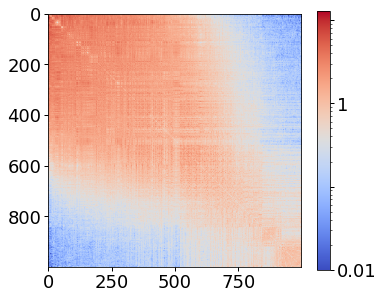

In [115]:
vmax = 13
vmin=0.01
class MinOneMaxFormatter(ticker.LogFormatter):
    def set_locs(self, locs=None):
        self._sublabels = set([vmin % 10 * 10, vmax % 10, 1])

    def __call__(self, x, pos=None):
        if x not in [vmin, 1, vmax]:
            return ""
        else:
            return "{x:g}".format(x=x)

norm = LogNorm(vmax=vmax, vmin=vmin)
im = plt.imshow(contacts_sorted, cmap="coolwarm", norm=norm)
cb = plt.colorbar(im, format=MinOneMaxFormatter())
cb.ax.yaxis.set_minor_formatter(MinOneMaxFormatter())

In [163]:
def saddle(e1, oe, n_bins):
    e1_sort_inds = np.argsort(e1)
    sorted_map = oe[e1_sort_inds, :][:, e1_sort_inds]
    interaction_sum = np.zeros((n_bins + 2, n_bins + 2))
    interaction_count = np.zeros((n_bins + 2, n_bins + 2))
    bins_per_quantile = int(sorted_map.shape[0] / (n_bins + 2))
    for n in range(n_bins + 2):
        data = sorted_map[n * bins_per_quantile : (n+1)*bins_per_quantile, :]
        for m in range(n_bins + 2):
            square = data[:, m * bins_per_quantile : (m+1)*bins_per_quantile]
            square = square[np.isfinite(square)]
            interaction_sum[n, m] = np.sum(square)
            interaction_count[n, m] = float(len(square))
    interaction_count += interaction_count.T
    interaction_sum += interaction_sum.T
    return interaction_sum, interaction_count

In [164]:
S, C = saddle(e1_19x, comp19x_oe, N_GROUPS)

In [153]:
import warnings
from cytoolz import merge

def saddleplot(
    track,
    saddledata,
    n_bins,
    tag,
    vrange=None,
    qrange=(0.0, 1.0),
    cmap="coolwarm",
    scale="log",
    vmin=0.5,
    vmax=2,
    color=None,
    title=None,
    xlabel=None,
    ylabel=None,
    clabel=None,
    fig=None,
    fig_kws=None,
    heatmap_kws=None,
    margin_kws=None,
    cbar_kws=None,
    subplot_spec=None,
):
    """
    Generate a saddle plot.
    Parameters
    ----------
    track : pd.DataFrame
        See cooltools.digitize() for details.
    saddledata : 2D array-like
        Saddle matrix produced by `make_saddle`. It will include 2 flanking
        rows/columns for outlier signal values, thus the shape should be
        `(n+2, n+2)`.
    cmap : str or matplotlib colormap
        Colormap to use for plotting the saddle heatmap
    scale : str
        Color scaling to use for plotting the saddle heatmap: log or linear
    vmin, vmax : float
        Value limits for coloring the saddle heatmap
    color : matplotlib color value
        Face color for margin bar plots
    fig : matplotlib Figure, optional
        Specified figure to plot on. A new figure is created if none is
        provided.
    fig_kws : dict, optional
        Passed on to `plt.Figure()`
    heatmap_kws : dict, optional
        Passed on to `ax.imshow()`
    margin_kws : dict, optional
        Passed on to `ax.bar()` and `ax.barh()`
    cbar_kws : dict, optional
        Passed on to `plt.colorbar()`
    subplot_spec : GridSpec object
        Specify a subregion of a figure to using a GridSpec.
    Returns
    -------
    Dictionary of axes objects.
    """

#     warnings.warn(
#         "Generating a saddleplot will be deprecated in future versions, "
#         + "please see https://github.com/open2c_examples for examples on how to plot saddles.",
#         DeprecationWarning,
#     )

    from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
    from matplotlib.colors import Normalize, LogNorm
    from matplotlib import ticker
    import matplotlib.pyplot as plt

    class MinOneMaxFormatter(ticker.LogFormatter):
        def set_locs(self, locs=None):
            self._sublabels = set([vmin % 10 * 10, vmax % 10, 1])

        def __call__(self, x, pos=None):
            if x not in [vmin, 1, vmax]:
                return ""
            else:
                return "{x:g}".format(x=x)

    df, binedges = digitize_track(track, qrange, n_bins)
    e1mean = df['E1'].groupby(df['E1.d']).mean()
    print(e1mean.shape)
    print(binedges.shape)

    if qrange is not None:
        lo, hi = qrange
        binedges = np.linspace(lo, hi, n_bins + 1)

    # Barplot of mean values and saddledata are flanked by outlier bins
    n = saddledata.shape[0]
    X, Y = np.meshgrid(binedges, binedges)
    C = saddledata
    if (n - n_bins) == 2:
        C = C[1:-1, 1:-1]
        e1mean = e1mean[1:-1]

    # Layout
    if subplot_spec is not None:
        GridSpec = partial(GridSpecFromSubplotSpec, subplot_spec=subplot_spec)
    grid = {}
    gs = GridSpec(
        nrows=3,
        ncols=3,
        width_ratios=[0.2, 1, 0.1],
        height_ratios=[0.2, 1, 0.1],
        wspace=0.05,
        hspace=0.05,
    )

    # Figure
    if fig is None:
        fig_kws_default = dict(figsize=(5, 5))
        fig_kws = merge(fig_kws_default, fig_kws if fig_kws is not None else {})
        fig = plt.figure(**fig_kws)

    # Heatmap
    if scale == "log":
        norm = LogNorm(vmin=vmin, vmax=vmax)
    elif scale == "linear":
        norm = Normalize(vmin=vmin, vmax=vmax)
    else:
        raise ValueError("Only linear and log color scaling is supported")

    grid["ax_heatmap"] = ax = plt.subplot(gs[4])
    heatmap_kws_default = dict(cmap="coolwarm", rasterized=True)
    heatmap_kws = merge(
        heatmap_kws_default, heatmap_kws if heatmap_kws is not None else {}
    )
    img = ax.pcolormesh(X, Y, C, norm=norm, **heatmap_kws)
    plt.gca().yaxis.set_visible(False)

    # Margins
    margin_kws_default = dict(edgecolor="k", facecolor=color, linewidth=1)
    margin_kws = merge(margin_kws_default, margin_kws if margin_kws is not None else {})
    # left margin hist
    grid["ax_margin_y"] = plt.subplot(gs[3], sharey=grid["ax_heatmap"])

    plt.barh(
        binedges[:-1], height=1/len(binedges), width=e1mean, align="edge", **margin_kws
    )

    plt.xlim(plt.xlim()[1], plt.xlim()[0])  # fliplr
    plt.ylim(hi, lo)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["bottom"].set_visible(False)
    plt.gca().spines["left"].set_visible(False)
    plt.gca().xaxis.set_visible(False)
    # top margin hist
    grid["ax_margin_x"] = plt.subplot(gs[1], sharex=grid["ax_heatmap"])

    plt.bar(
        binedges[:-1], width=1/len(binedges), height=e1mean, align="edge", **margin_kws
    )

    plt.xlim(lo, hi)
    # plt.ylim(plt.ylim())  # correct
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.gca().spines["left"].set_visible(False)
    plt.gca().xaxis.set_visible(False)
    plt.gca().yaxis.set_visible(False)

    # Colorbar
    grid["ax_cbar"] = plt.subplot(gs[5])
    cbar_kws_default = dict(fraction=0.8, label=clabel or "")
    cbar_kws = merge(cbar_kws_default, cbar_kws if cbar_kws is not None else {})
    if scale == "linear" and vmin is not None and vmax is not None:
        grid["cbar"] = cb = plt.colorbar(img, **cbar_kws)
        # cb.set_ticks(np.arange(vmin, vmax + 0.001, 0.5))
        # # do linspace between vmin and vmax of 5 segments and trunc to 1 decimal:
        decimal = 10
        nsegments = 5
        cd_ticks = np.trunc(np.linspace(vmin, vmax, nsegments) * decimal) / decimal
        cb.set_ticks(cd_ticks)
    else:
        grid["cbar"] = cb = plt.colorbar(img, format=MinOneMaxFormatter(), **cbar_kws)
        cb.ax.yaxis.set_minor_formatter(MinOneMaxFormatter())

    # extra settings
    grid["ax_heatmap"].set_xlim(lo, hi)
    grid["ax_heatmap"].set_ylim(hi, lo)
    plt.grid(False)
    plt.axis("off")
    if title is not None:
        grid["ax_margin_x"].set_title(title)
    if xlabel is not None:
        grid["ax_heatmap"].set_xlabel(xlabel)
    if ylabel is not None:
        grid["ax_margin_y"].set_ylabel(ylabel)
    
    fig.tight_layout()
    plt.savefig(f'plots/{tag}_E1_saddle.pdf')
    return grid

(40,)
(39,)


/tmp/ipykernel_28284/3339992419.py:180: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  grid["cbar"] = cb = plt.colorbar(img, format=MinOneMaxFormatter(), **cbar_kws)
/tmp/ipykernel_28284/3339992419.py:195: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


{'ax_heatmap': <AxesSubplot:>,
 'ax_margin_y': <AxesSubplot:>,
 'ax_margin_x': <AxesSubplot:>,
 'ax_cbar': <AxesSubplot:>,
 'cbar': <matplotlib.colorbar.Colorbar at 0x7f0707fc3580>}

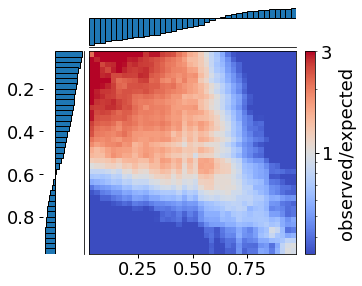

In [174]:
saddleplot(
    e1_19x,
    S / C,
    N_GROUPS,
    'comp19x',
    qrange=(Q_LO, Q_HI),
    vmin=1./3.0, vmax=3.0, 
    cbar_kws={'label':'observed/expected'}
)

(40,)
(39,)


/tmp/ipykernel_28284/3339992419.py:180: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  grid["cbar"] = cb = plt.colorbar(img, format=MinOneMaxFormatter(), **cbar_kws)
/tmp/ipykernel_28284/3339992419.py:195: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


{'ax_heatmap': <AxesSubplot:>,
 'ax_margin_y': <AxesSubplot:>,
 'ax_margin_x': <AxesSubplot:>,
 'ax_cbar': <AxesSubplot:>,
 'cbar': <matplotlib.colorbar.Colorbar at 0x7f07077a9460>}

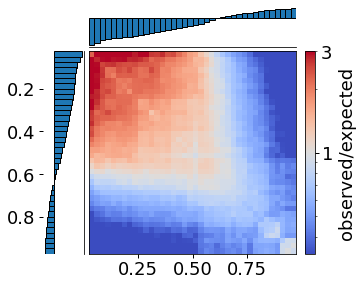

In [178]:
S_10x, C_10x = saddle(e1_10x, comp10x_oe, N_GROUPS)
saddleplot(
    e1_10x,
    S_10x / C_10x,
    N_GROUPS,
    'comp10x',
    qrange=(Q_LO, Q_HI),
    vmin=1./3., vmax=3.0, 
    cbar_kws={'label':'observed/expected'}
)

(40,)
(39,)


/tmp/ipykernel_28284/3339992419.py:172: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  grid["cbar"] = cb = plt.colorbar(img, **cbar_kws)
/tmp/ipykernel_28284/3339992419.py:195: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


{'ax_heatmap': <AxesSubplot:>,
 'ax_margin_y': <AxesSubplot:>,
 'ax_margin_x': <AxesSubplot:>,
 'ax_cbar': <AxesSubplot:>,
 'cbar': <matplotlib.colorbar.Colorbar at 0x7f070788a730>}

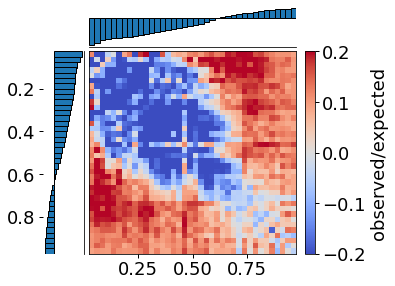

In [177]:
saddleplot(
    e1_10x,
    (S_10x / C_10x) - (S/C),
    N_GROUPS,
    'comp10x_19x_diff',
    qrange=(Q_LO, Q_HI),
    scale="linear",
            vmin = -0.2, vmax=0.2,
    cbar_kws={'label':'observed/expected'}
)

In [269]:
def saddle_strength_A_B(S, C):
    """
    Parameters
    ----------
    S, C : 2D arrays, square, same shape
        Saddle sums and counts, respectively

    Returns
    -------
    Astrength : 1d array
        Ratios of cumulative corner interaction scores (AA/AB) with increasing extent.
    Bstrength : 1d array
        Ratios of cumulative corner interaction scores (BB/AB) with increasing extent

    """
    m, n = S.shape
    if m != n:
        raise ValueError("`saddledata` should be square.")
    
    AA_oe = np.zeros(n)
    BB_oe = np.zeros(n)
    AB_oe = np.zeros(n)
    AA_ratios = np.zeros(n)
    BB_ratios = np.zeros(n)
    ratios = np.zeros(n)
    for k in range(1, n):
        BB_sum = np.nansum(S[0:k, 0:k])
        AA_sum = np.nansum(S[n - k : n, n - k : n])
        BB_count = np.nansum(C[0:k, 0:k])
        AA_count = np.nansum(C[n - k : n, n - k : n])
        AA = AA_sum / AA_count
        BB = BB_sum / BB_count
        intra_sum = AA_sum + BB_sum
        intra_count = AA_count + BB_count
        intra = intra_sum / intra_count
        AB_sum = np.nansum(S[0:k, n - k : n]) 
        inter_sum = AB_sum + np.nansum(S[n - k : n, 0:k])
        AB_count = np.nansum(C[0:k, n - k : n]) 
        inter_count = AB_count + np.nansum(C[n - k : n, 0:k])
        inter = inter_sum / inter_count
        AB = AB_sum / AB_count
        AA_ratios[k] = AA / AB
        BB_ratios[k] = BB / AB
        AA_oe[k] = AA
        BB_oe[k] = BB
        AB_oe[k] = AB
        ratios[k] = intra / inter
    return AA_oe, BB_oe, AB_oe, AA_ratios, BB_ratios, ratios

In [266]:
def plot_saddle_strength_AB(datasets, labels, figtag='blobel', q=25, ratios=True, plotAB=False):
    """ Plot 2-panel figure showing AA strength (one curve per dataset) and BB strength.
    
    Parameters
    ----------
    datasets: list of tuples
        list of tuples (interaction_sum, interaction_count), one per dataset
    
    """
    fig, ax = plt.subplots()
    x = np.arange(N_GROUPS + 2)
    quantiles = np.linspace(0, Q_HI, N_GROUPS + 2)
    ind = int(q // 2.5)
    print(quantiles[ind])
    color_order = [5, 1, 4, 0]
    AB_color_order = [3, 2]
    colors = sns.color_palette("Paired", 6)
    for j, saddle in enumerate(datasets):
        S, C = saddle
        AA, BB, AB, AA_ratios, BB_ratios, ratios = saddle_strength_A_B(S, C)
        print(f'Top {q}% of AA / AB for {labels[j]}: {AA_ratios[ind]}')
        print(f'Top {q}% of BB / AB for {labels[j]}: {BB_ratios[ind]}')
        if ratios:
            ax.step(quantiles, AA_ratios, where="pre", color=colors[color_order[2*j]], label='AA/AB, ' + labels[j])
            ax.step(quantiles, BB_ratios, where="pre", color=colors[color_order[2*j + 1]], label='BB/AB, ' + labels[j])
        else:
            ax.step(quantiles, AA, where="pre", color=colors[color_order[2*j]], label='AA, ' + labels[j])
            ax.step(quantiles, BB, where="pre", color=colors[color_order[2*j + 1]], label='BB, ' + labels[j])
        if plotAB:
            ax.step(quantiles, AB, where="pre", color=colors[AB_color_order[j]], label='AB, ' + labels[j])
    plt.legend(loc="upper right")
    plt.xlabel('E1 quantiles')
    plt.ylabel('Interaction strength')
    plt.title('saddle strength profile')
    if ratios:
        plt.axhline(1, c='grey', ls='--', lw=1) 
    plt.xlim(left=0)
    fig.tight_layout()
    plt.savefig(f'plots/E1_saddle_strength_{figtag}.pdf')
        

0.24999999999999997
Top 25% of AA / AB for $D_A / D_B = 19$: 4.11600815896519
Top 25% of BB / AB for $D_A / D_B = 19$: 20.416468476574384
Top 25% of AA / AB for $D_A / D_B = 10$: 2.197377957912347
Top 25% of BB / AB for $D_A / D_B = 10$: 9.595529650530153


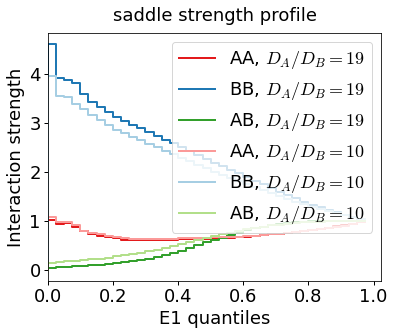

In [199]:
datasets = [(S, C), (S_10x, C_10x)]
labels = [r'$D_A / D_B = 19$', r'$D_A / D_B = 10$'] 
plot_saddle_strength_AB(datasets, labels, figtag='sim_comps_19_19', plotAB=True, ratios=False)

0.24999999999999997
Top 25% of AA / AB for $D_A / D_B = 19$: 4.11600815896519
Top 25% of BB / AB for $D_A / D_B = 19$: 20.416468476574384
Top 25% of AA / AB for $D_A / D_B = 10$: 2.197377957912347
Top 25% of BB / AB for $D_A / D_B = 10$: 9.595529650530153


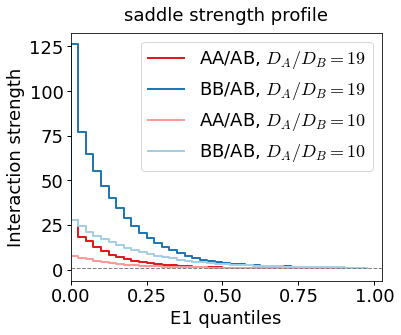

In [191]:
plot_saddle_strength_AB(datasets, labels, figtag='sim_comps_19_19', plotAB=False, ratios=True)

# Streamlined pipeline for saddle plots from simulation data

In [214]:
#load data, balance, compute e1
def process_data(filename):
    contactmap = np.load(filename)
    mat_balanced, totalBias, report = iterative_correction_symmetric(contactmap, max_iter=50)
    mat_balanced /= np.mean(mat_balanced.sum(axis=1))
    #compute observed over expected
    mat_oe, dist_bins, sum_pixels, n_pixels = observed_over_expected(mat_balanced)
    #mean center and compute e1
    mat_oe_norm = mat_oe - 1.0
    eigvecs, eigvals = numutils.get_eig(mat_oe_norm, 3, mask_zero_rows=True)
    eigvecs /= np.sqrt(np.nansum(eigvecs ** 2, axis=1))[:, None]
    eigvecs *= np.sqrt(np.abs(eigvals))[:, None]
    e1 = eigvecs[0]
    return mat_balanced, mat_oe, e1


In [215]:
comps7x_balanced, comps7x_oe, e1_7x = process_data('contactmaps/contact_map_comps_7x_cutoff2.0.npy')

(40,)
(39,)


/tmp/ipykernel_28284/3339992419.py:180: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  grid["cbar"] = cb = plt.colorbar(img, format=MinOneMaxFormatter(), **cbar_kws)
/tmp/ipykernel_28284/3339992419.py:195: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


{'ax_heatmap': <AxesSubplot:>,
 'ax_margin_y': <AxesSubplot:>,
 'ax_margin_x': <AxesSubplot:>,
 'ax_cbar': <AxesSubplot:>,
 'cbar': <matplotlib.colorbar.Colorbar at 0x7f0704822ca0>}

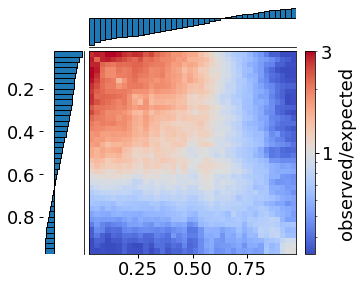

In [241]:
S_7x, C_7x = saddle(e1_7x, comps7x_oe, N_GROUPS)
saddleplot(
    e1_7x,
    S_7x / C_7x,
    N_GROUPS,
    'comp7x',
    vmin = 1./3., vmax=3.0,
    qrange=(Q_LO, Q_HI),
    cbar_kws={'label':'observed/expected'}
)

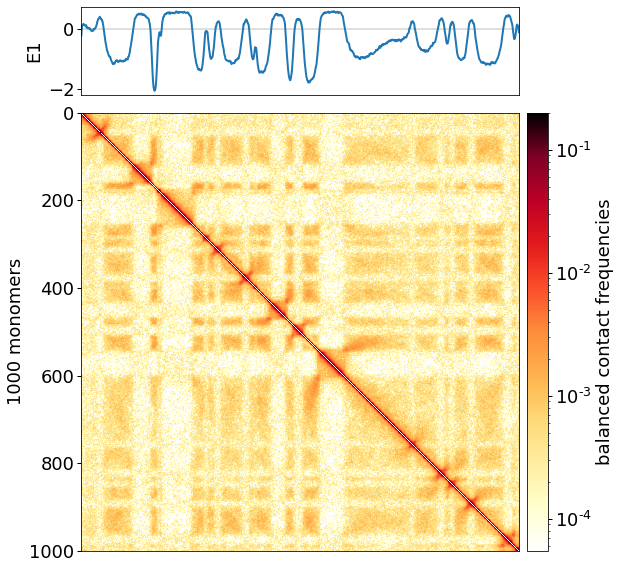

In [231]:
plot_E1_simulated_contact_map(comps7x_balanced, e1_7x, 'comp7x', lines=False)

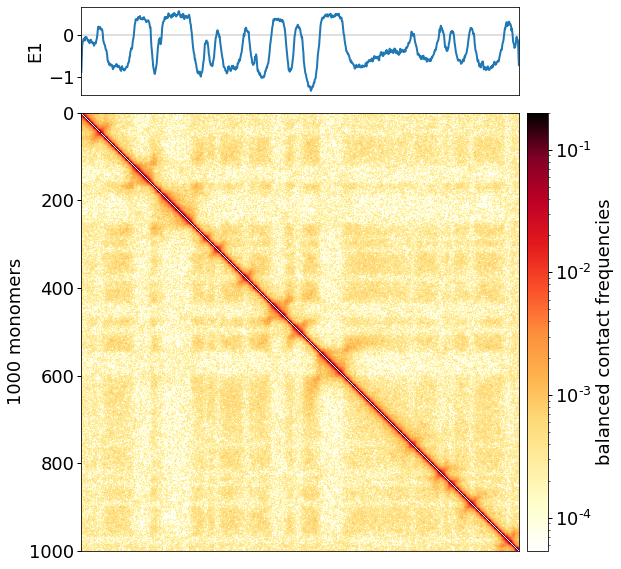

In [227]:
comps4x_balanced, comps4x_oe, e1_4x = process_data('contactmaps/contact_map_comps_4x_cutoff2.0.npy')
plot_E1_simulated_contact_map(comps4x_balanced, e1_4x, 'comp4x', lines=False)

(40,)
(39,)


/tmp/ipykernel_28284/3339992419.py:180: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  grid["cbar"] = cb = plt.colorbar(img, format=MinOneMaxFormatter(), **cbar_kws)
/tmp/ipykernel_28284/3339992419.py:195: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


{'ax_heatmap': <AxesSubplot:>,
 'ax_margin_y': <AxesSubplot:>,
 'ax_margin_x': <AxesSubplot:>,
 'ax_cbar': <AxesSubplot:>,
 'cbar': <matplotlib.colorbar.Colorbar at 0x7f07034e98e0>}

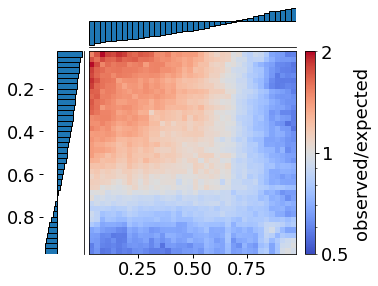

In [233]:
S_4x, C_4x = saddle(e1_4x, comps4x_oe, N_GROUPS)
saddleplot(
    e1_4x,
    S_4x / C_4x,
    N_GROUPS,
    'comp7x',
    qrange=(Q_LO, Q_HI),
    vmin=0.5, vmax=2.0, 
    cbar_kws={'label':'observed/expected'}
)

(40,)
(39,)


/tmp/ipykernel_28284/3339992419.py:172: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  grid["cbar"] = cb = plt.colorbar(img, **cbar_kws)
/tmp/ipykernel_28284/3339992419.py:195: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


{'ax_heatmap': <AxesSubplot:>,
 'ax_margin_y': <AxesSubplot:>,
 'ax_margin_x': <AxesSubplot:>,
 'ax_cbar': <AxesSubplot:>,
 'cbar': <matplotlib.colorbar.Colorbar at 0x7f07045ea4c0>}

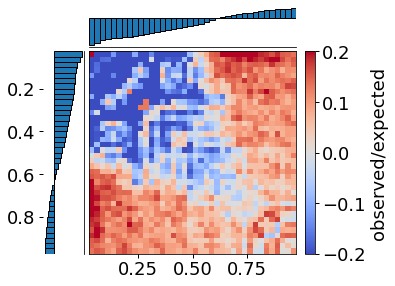

In [240]:
saddleplot(
    e1_10x,
    (S_7x / C_7x) - (S_10x / C_10x),
    N_GROUPS,
    'diff_7x_10x',
    qrange=(Q_LO, Q_HI),
    scale="linear",
            vmin = -0.2, vmax=0.2, 
    cbar_kws={'label':'observed/expected'}
)

0.24999999999999997
Top 25% of AA / AB for $D_A / D_B = 7$: 1.6590942333147125
Top 25% of BB / AB for $D_A / D_B = 7$: 5.8262372943292355
Top 25% of AA / AB for $D_A / D_B = 4$: 1.1645830598696763
Top 25% of BB / AB for $D_A / D_B = 4$: 2.452142553028044


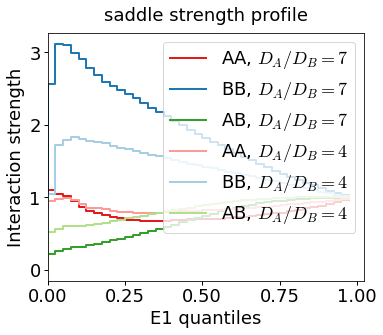

In [229]:
datasets = [(S_7x, C_7x), (S_4x, C_4x)]
labels = [r'$D_A / D_B = 7$', r'$D_A / D_B = 4$'] 
plot_saddle_strength_AB(datasets, labels, figtag='sim_comps_7_4', plotAB=True, ratios=False)

0.24999999999999997
Top 25% of AA / AB for $D_A / D_B = 7$: 1.6590942333147125
Top 25% of BB / AB for $D_A / D_B = 7$: 5.8262372943292355
Top 25% of AA / AB for $D_A / D_B = 4$: 1.1645830598696763
Top 25% of BB / AB for $D_A / D_B = 4$: 2.452142553028044


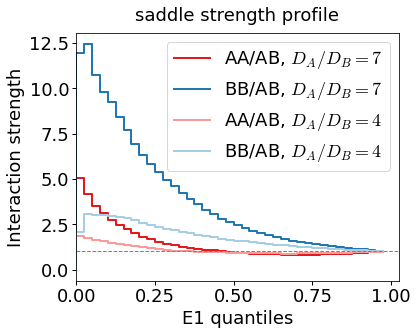

In [230]:
plot_saddle_strength_AB(datasets, labels, figtag='sim_comps_7_4_ratios', ratios=True)

0.24999999999999997
Top 25% of AA / AB for $D_A / D_B = 10$: 2.197377957912347
Top 25% of BB / AB for $D_A / D_B = 10$: 9.595529650530153
Top 25% of AA / AB for $D_A / D_B = 7$: 1.6590942333147125
Top 25% of BB / AB for $D_A / D_B = 7$: 5.8262372943292355


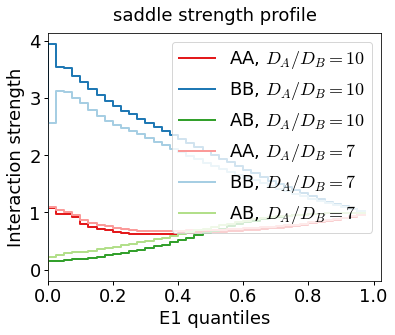

In [235]:
datasets = [(S_10x, C_10x), (S_7x, C_7x)]
labels = [r'$D_A / D_B = 10$', r'$D_A / D_B = 7$'] 
plot_saddle_strength_AB(datasets, labels, figtag='sim_comps_10_7', plotAB=True, ratios=False)

0.24999999999999997
Top 25% of AA / AB for $D_A / D_B = 10$: 2.197377957912347
Top 25% of BB / AB for $D_A / D_B = 10$: 9.595529650530153
Top 25% of AA / AB for $D_A / D_B = 7$: 1.6590942333147125
Top 25% of BB / AB for $D_A / D_B = 7$: 5.8262372943292355


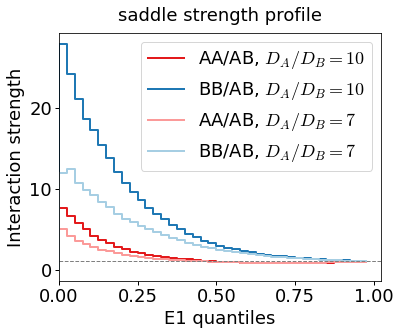

In [236]:
plot_saddle_strength_AB(datasets, labels, figtag='sim_comps_10_7_ratios', ratios=True)